# Simple DQN Agent

Modified version of https://pylessons.com/CartPole-reinforcement-learning/

To-Do:

* Double DQN: Regular DQN overestimates Q-value. Decouble action choice from target Q-value generation.
* Dueling DQN: Have a network that separately computes the advantage and value functions and later combines them into a single Q-function 
* Different exploration strategies with ActionWrappers
* Other methods of experience replay like PER -> https://pylessons.com/CartPole-PER/

To-Do for safety:
* Optimization: Bayesian, Genetic, or ant-colony
* Monte Carlo tree search
* Importance sampling: Cross entropy method
   

# Imports

In [3]:
# Disable annoying tf2 warnings
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import matplotlib
%matplotlib inline

import random
import gym
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Agent Model

In [1]:

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=2000)  # history
        self.gamma = 0.95                 # discount rate
        self.epsilon = 1.0                # exploration rate
        self.epsilon_min = 0.01           # minimum exploration probablity
        self.epsilon_decay = 0.995        # exponential decay rate over time
        self.learning_rate = 0.001        # step size at each iteration

        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.state_size, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)




# Training

In [10]:
def train_agent(env, agent, episodes=1000):
    done = False
    batch_size = 32
    scores = []

    for e in range(episodes):
      state = env.reset()
      state = np.reshape(state, [1, state_size])
      for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        if done:
          scores.append(time)
          print(f"episode: {e}/{episodes}, score: {time}, e: {agent.epsilon}")
          break
        if len(agent.memory) > batch_size:
          agent.replay(batch_size)
        
    return agent, scores

# Usage

In [11]:
env = gym.make('CartPole-v1')
env.seed(0)
np.random.seed(0)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

agent, scores= train_agent(env, agent)
agent.save('dqn.h5')

#agent = agent.load('dqn.h5')


episode: 0/1000, score: 14, e: 1.0
episode: 1/1000, score: 21, e: 0.9801495006250001
episode: 2/1000, score: 28, e: 0.851801859600347
episode: 3/1000, score: 16, e: 0.7861544476842928
episode: 4/1000, score: 11, e: 0.7439808620067382
episode: 5/1000, score: 14, e: 0.6935613678313175
episode: 6/1000, score: 18, e: 0.6337242817644086
episode: 7/1000, score: 10, e: 0.6027415843082742
episode: 8/1000, score: 15, e: 0.5590843898207511
episode: 9/1000, score: 15, e: 0.5185893309484582
episode: 10/1000, score: 13, e: 0.4858739637363176
episode: 11/1000, score: 10, e: 0.46211964903917074
episode: 12/1000, score: 10, e: 0.43952667968844233
episode: 13/1000, score: 10, e: 0.4180382776616619
episode: 14/1000, score: 9, e: 0.3995984329713264
episode: 15/1000, score: 12, e: 0.37627099809304654
episode: 16/1000, score: 15, e: 0.34901730169741024
episode: 17/1000, score: 12, e: 0.32864265128599696
episode: 18/1000, score: 9, e: 0.3141460853680822
episode: 19/1000, score: 8, e: 0.3017979588795719
epis

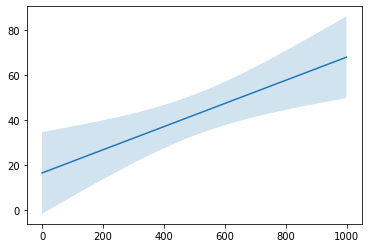

In [45]:
x = np.arange(1000)
a, b = np.polyfit(x, scores, 1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) + (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig1, ax1 = plt.subplots()
ax1.plot(x, y_est, '-')
ax1.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fd01c4267f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd01c4328d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd01c4269b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd01c432e80>],
 'fliers': [],
 'means': []}

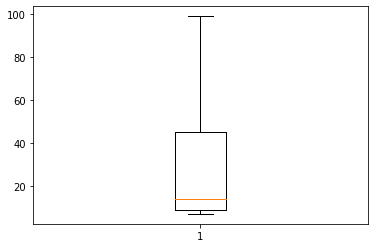

In [47]:
fig2, ax2 = plt.subplots()
ax2.boxplot(scores, showfliers=False)

NameError: name 'plt' is not defined